In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras import optimizers

In [0]:
df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/RELIANCE.NS?period1=1556841600&period2=1588464000&interval=1d&events=history")

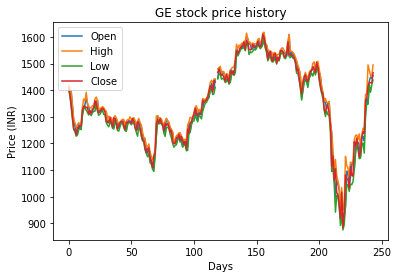

In [0]:
plt.figure()
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (INR)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

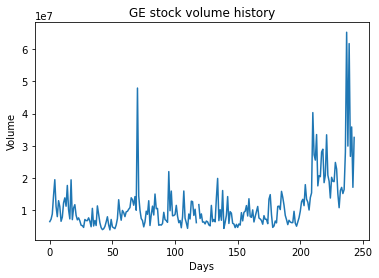

In [0]:
plt.figure()
plt.plot(df["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [0]:
train_cols = ["Open","High","Low","Close","Volume"]
X_train, X_test, y_train, y_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

ValueError: ignored

In [0]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.01)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [0]:
history = lstm_model.fit(x_t, y_t, epochs=10, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_train, BATCH_SIZE),
                    trim_dataset(y_train, BATCH_SIZE)), callbacks=[csv_logger])

NameError: ignored

In [0]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
# import talos as ta

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Kolkata'  # to set timezone; needed when running on cloud
time.tzset()

params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

iter_changes = "dropout_layers_0.4_0.4"

INPUT_PATH = "https://query1.finance.yahoo.com/v7/finance/download/RELIANCE.NS?period1=1556841600&period2=1588464000&interval=1d&events=history"
OUTPUT_PATH = "/outputs/lstm_best_7-3-19_12AM/"+iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

# check if directory already exists

def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")


def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


stime = time.time()
#print(os.listdir(INPUT_PATH))
df_ge = pd.read_csv(INPUT_PATH, engine='python')
print(df_ge.shape)
print(df_ge.columns)
display(df_ge.head(5))
tqdm_notebook.pandas('Processing...')
# df_ge = process_dataframe(df_ge)
print(df_ge.dtypes)
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

print("Deleting unused dataframes of total size(KB)",(sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)

del df_ge
del df_test
del df_train
del x

print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)


def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model


model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")


x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)
    
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))

# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)

(244, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-03,1407.949951,1417.500000,1402.650024,1408.849976,1401.091064,6510169.0
1,2019-05-06,1398.000000,1402.800049,1378.099976,1384.900024,1377.272949,7237910.0
2,2019-05-07,1394.800049,1395.000000,1340.199951,1343.500000,1336.100952,8877095.0
3,2019-05-08,1340.000000,1340.000000,1292.199951,1299.449951,1292.293457,14610543.0
4,2019-05-09,1288.800049,1288.800049,1251.750000,1256.449951,1249.530273,19507368.0


Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object
Train--Test size 195 49
Deleting unused dataframes of total size(KB) 56
Are any NaNs present in train/test matrices? True True
dim_0 135



length of time-series i/o (135, 60, 5) (135,)
Batch trimmed size (120, 60, 5) (120,)
Model not found


ValueError: ignored

In [0]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split

#creating dataframe
df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/RELIANCE.NS?period1=1556841600&period2=1588464000&interval=1d&events=history")
df = df.dropna()

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

#setting index
y = df["Close"].values
X = range(len(y))
#X = [[d] for d in range(len(y))]
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, 1)
X_test = X_test.reshape(X_test.shape[0], 1, 1)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

closing_price = model.predict(X_test)

Epoch 1/10
 - 1s - loss: 1795214.3009
Epoch 2/10
 - 0s - loss: 1763390.6806
Epoch 3/10
 - 0s - loss: 1743657.7303
Epoch 4/10
 - 0s - loss: 1725663.7809
Epoch 5/10
 - 0s - loss: 1708326.1296
Epoch 6/10
 - 0s - loss: 1691408.9425
Epoch 7/10
 - 0s - loss: 1674774.8870
Epoch 8/10
 - 0s - loss: 1658365.4934
Epoch 9/10
 - 0s - loss: 1642148.5135
Epoch 10/10
 - 0s - loss: 1626108.2284


In [0]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split

#creating dataframe
df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/RELIANCE.NS?period1=1556841600&period2=1588464000&interval=1d&events=history")
df = df.dropna()

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

#setting index
y = df["Close"].values
X = range(len(y))
days = X
#X = [[d] for d in range(len(y))]
X = np.array(X)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#X_train = X_train.reshape(X_train.shape[0], 1, 1)
X = X.reshape(X.shape[0], 1, 1)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, epochs=10, batch_size=1, verbose=2)

closing_price = model.predict(X)

Epoch 1/10
 - 1s - loss: 1804236.2989
Epoch 2/10
 - 1s - loss: 1768036.9113
Epoch 3/10
 - 1s - loss: 1741050.3261
Epoch 4/10
 - 1s - loss: 1715422.5772
Epoch 5/10
 - 1s - loss: 1690487.1836
Epoch 6/10
 - 1s - loss: 1665984.4200
Epoch 7/10
 - 1s - loss: 1641849.0358
Epoch 8/10
 - 1s - loss: 1618018.7410
Epoch 9/10
 - 1s - loss: 1594482.3943
Epoch 10/10
 - 1s - loss: 1571217.8269


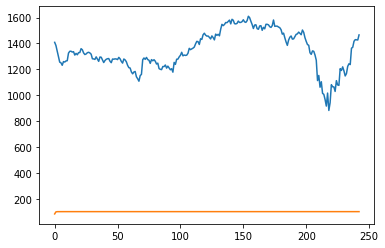

In [0]:
plt.plot(days, y)
plt.plot(days, closing_price)
plt.show()

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Categorical
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [0]:
# df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/RELIANCE.NS?period1=1556841600&period2=1588464000&interval=1d&events=history") # 1Y
# df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/RELIANCE.NS?period1=1583193600&period2=1588464000&interval=1d&events=history") # 3M
# df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/RELIANCE.NS?period1=1554249600&period2=1588464000&interval=1d&events=history") # 1M
# df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/RELIANCE.NS?period1=1588032000&period2=1588464000&interval=1d&events=history") # 3D

df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/BANDHANBNK.NS?period1=1585872000&period2=1588464000&interval=1d&events=history") # 1M
df = df.dropna()
df["Date"] = Categorical(df["Date"]).codes

In [0]:
n_steps = len(df)
n_features = 2

In [0]:
X = df[["Date", "Open"]].values
X = X.reshape((X.shape[0], X.shape[1], 1))
days = range(len(df))
y = df["Close"].values

In [393]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=3000, verbose=0)

In [0]:
y_pred = model.predict(X, verbose=0)

[]

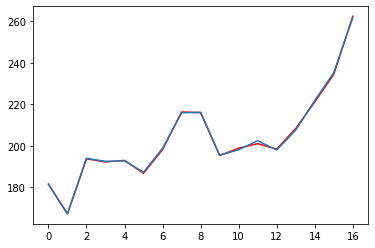

In [395]:
plt.plot(days, y, 'r')
plt.plot(days, y_pred)
plt.plot()

In [397]:
y_pred = model.predict(np.array([[[len(df)], [1453.95]]]), verbose=0)
print(y_pred)

[[1132.1407]]
